In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.metrics import r2_score
import glob

In [2]:
class BarCode:

	def __init__(self, enmo, int_thresholds, duration_thresholds):
		self.entropy = -1
		self.sample_entropy = -1
		self.lzc = -1
		self.percent_active = -1
		self.int_thresholds = int_thresholds
		self.dur_thresholds = duration_thresholds
		self.sbs_enmo = enmo
		self.barcode = self.create_barcode()
		self.no_classes = np.concatenate(np.array(self.dur_thresholds)).shape[0]
		self.compute_entropy()
		#self.compute_lzc()
		self.compute_percent_active(4)
		self.compute_sample_entropy(3,1)

	def compute_entropy(self):
		entropy = information_entropy(self.barcode[:, 1])
		self.entropy = entropy

	def compute_sample_entropy(self, length, radius):
		self.sample_entropy = sample_entropy(self.barcode[:, 1], length, radius)

	def compute_lzc(self):
		self.lzc = lzc(self.barcode[:, 1])

	def compute_percent_active(self, active_threshold):
		self.percent_active = 100 * np.mean(self.barcode[:, 1] >= active_threshold)

	def create_barcode(self):
		#acc, frequency = read_bin(self.bin)
		#enmo = compute_enmo(acc)
		#econd_by_second_enmo = second_by_second(enmo, frequency)
		return barcoder(self.sbs_enmo, self.int_thresholds, self.dur_thresholds)

class Day:
	def __init__(self, acc_table, freq, threshold, percent, raw_data, day, ID):

		# Proportion of possible seconds covered
		self.size = (acc_table.shape[0]) / 86400
		self.frequency_acc = freq

		#self.valid_hours_acc = np.mean(valid_hours(acc_table[:, 2:5],acc_table[:, 5], self.frequency_acc)) * 24 * self.size
		self.enmo = acc_table[:, 6]
		self.top = np.mean(self.enmo > np.mean(self.enmo))
		self.left = np.sum(self.enmo[self.enmo.shape[0]//2:])/np.sum(self.enmo)
		event_list = create_events(np.minimum(acc_table[:, 6], threshold), threshold, percent)
		event_list = np.array([x for x in event_list if x[1]>9])

		self.event_tab = [Event(x[0], x[1], acc_table[x[0]:(x[0] + x[1]), 6],
                                raw_data[(freq*x[0]):(freq*(x[0] + x[1]))], self.frequency_acc) 
                                for x in  event_list]
		self.Day_tab = pd.DataFrame([x.print_all() for x in self.event_tab])
		self.barcode = BarCode(self.enmo)
		self.Day_tab['entropy'] = self.barcode.entropy
		#self.Day_tab['lzc'] = self.barcode.lzc
		self.Day_tab['sample'] = self.barcode.sample_entropy
		self.Day_tab['top'] = self.top
		self.Day_tab['left'] = self.left
		self.Day_tab['ID'] = ID
		self.Day_tab['Day'] = day


class Event:

	def __init__(self, start, length, acc, y_acc, freq):
		self.start_loc = start
		self.end_loc = start + length
		self.duration = length
		self.volume = np.sum(acc)
		self.sd = np.std(acc)
		self.intensity = self.volume / self.duration
		self.ptp = np.ptp(acc)
		self.freq = freq
		self.steps = self.stepper(y_acc)

	def stepper(self, acc):
		upper_filter = 5
		lower_filter = 0.5

		filtered = cheby_bandpass_filter(acc.flatten(),
		lowcut=lower_filter, highcut=upper_filter, fs=self.freq, order=2)

		cadence = compute_cadence(filtered, 0.1, self.freq)
		return cadence.shape[0] * 2

	def print_all(self):
		return np.array([self.start_loc, self.end_loc, self.duration, self.volume, self.sd, self.intensity, self.ptp, self.steps])

In [20]:
def plots_int(FILES, name, week):
	p = np.array([[x.Day_tab[4].max()for x in y[2] if 4 in x.Day_tab.columns] for y in FILES if len(y[2])>20])
	for i in range(p.shape[0]):
		p[i] = np.concatenate((np.array(p[i]), np.array(np.zeros(22-len(p[i])))))

	q = np.zeros((p.shape[0], 22))
	for i in np.arange(p.shape[0]):
		q[i] = p[i]
	weeks = np.zeros(3, dtype = np.object)
	weeks[0] = q[:, 0:7]
	weeks[1] = q[:, 7:14]
	weeks[2] = q[:, 14:21]

	scores = np.zeros((1200, 7))
	for ix, i in enumerate(np.linspace(0.01, 0.7, num = 1200)):
		for j in np.arange(7):

			scores[ix][j] = (np.sum(np.nansum(weeks[week] >= i, 1) >= j+1) * 100)/np.sum((weeks[week] > 0), 0)[j]
            

	plt.title('Period ' + str(name) + ' week ' + str(week+1))
	plt.plot(scores[:, 6], label = '7 days', color = 'b')
	plt.plot(scores[:, 5], label = '6 days', color = 'orange')
	plt.plot(scores[:, 4], label = '5 days', color = 'g')
	plt.plot(scores[:, 3], label = '4 days', color = 'r')
	plt.plot(scores[:, 2], label = '3 days', color = 'brown')
	plt.plot(scores[:, 1], label = '2 days', color = 'purple')
	plt.plot(scores[:, 0], label = '1 days', color = 'olive')
	plt.xlabel('Intensity (mg)')
	plt.xticks([0, 70, 140, 210, 280, 350, 420, 490, 560, 630, 700, 770, 840, 910, 980, 1050, 1120, 1190], 
               ('00', '50', '90','130', '170', '210', '250', '290','330', '370','410', '450', '490','530', '570', '610','650', '690', '730'), rotation = 45)
	plt.legend()
	plt.ylabel('Percent with bout above threshold')
    
	cols = ['b', 'orange', 'g', 'r', 'brown','purple','olive'][::-1]
	medians_loc = [np.where(scores[:, j]<50)[0][0] for j in np.arange(0,7)]
	for j, i in enumerate(medians_loc):
		plt.plot([i, i], [0, 50], color = cols[j])
		plt.plot([0, i], [50, 50], color = cols[j])
		print(np.linspace(0.01, 0.7, num = 1200)[i], end = ", ")     
	plt.show()

	return scores

def plots_dur(FILES, name, week):
	p = np.array([[x.Day_tab[2].max()for x in y[2] if 2 in x.Day_tab.columns] for y in FILES if len(y[2])>20])
	for i in range(p.shape[0]):
		p[i] = np.concatenate((np.array(p[i]), np.array(np.zeros(22-len(p[i])))))

	q = np.zeros((p.shape[0], 22))
	for i in np.arange(p.shape[0]):
		q[i] = p[i]
	weeks = np.zeros(3, dtype = np.object)
	weeks[0] = q[:, 0:7]
	weeks[1] = q[:, 7:14]
	weeks[2] = q[:, 14:21]

	scores = np.zeros((2400, 7))
	for ix, i in enumerate(np.arange(0, 2400)):
		for j in np.arange(7):

			scores[ix][j] = (np.sum(np.nansum(weeks[week] >= i+1, 1) >= j+1) * 100)/np.sum((weeks[week] > 0), 0)[j]
            

	plt.title('Period ' + str(name) + ' week ' + str(week+1))
	plt.plot(scores[:, 6], label = '7 days', color = 'b')
	plt.plot(scores[:, 5], label = '6 days', color = 'orange')
	plt.plot(scores[:, 4], label = '5 days', color = 'g')
	plt.plot(scores[:, 3], label = '4 days', color = 'r')
	plt.plot(scores[:, 2], label = '3 days', color = 'brown')
	plt.plot(scores[:, 1], label = '2 days', color = 'purple')
	plt.plot(scores[:, 0], label = '1 days', color = 'olive')
	plt.xlabel('Duration (s)')
	plt.legend()
	plt.ylabel('Percent with bout above threshold')
	
    
	cols = ['b', 'orange', 'g', 'r', 'brown','purple','olive'][::-1]
	medians_loc = [np.where(scores[:, j]<50)[0][0] for j in np.arange(0,7)]
	for j, i in enumerate(medians_loc):
		plt.plot([i, i], [0, 50], color = cols[j])
		plt.plot([0, i], [50, 50], color = cols[j])
		print([i], end = ", ")     
	     
	plt.show()

	return scores

In [4]:
A_Files = glob.glob('D:\\KNEE\\[0-9]?[A]*bin.npy')
B_Files = glob.glob('D:\\KNEE\\[0-9]?[B]*bin.npy')
C_Files = glob.glob('D:\\KNEE\\[0-9]?[C]*bin.npy')

C = np.array([np.load(x, allow_pickle = True) for x in C_Files])
B = np.array([np.load(x, allow_pickle = True) for x in B_Files])
A = np.array([np.load(x, allow_pickle = True) for x in A_Files])


Figure 1
0.34492910758965806, 0.2649374478732277, 0.23040867389491243, 0.2079649708090075, 0.17804003336113428, 0.15904920767306088, 0.12394495412844037, 

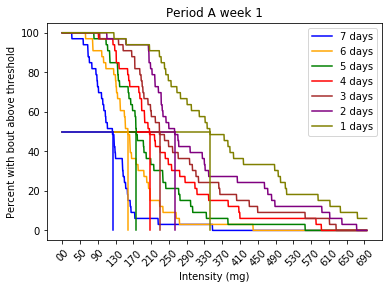

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 2
0.369674728940784, 0.306371976647206, 0.25515429524603833, 0.22522935779816514, 0.2056630525437865, 0.18437030859049208, 0.15099249374478732, 

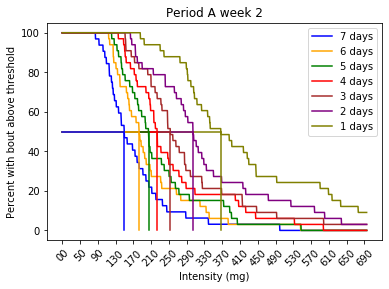

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 3
0.3771559633027523, 0.3242118432026689, 0.2447956630525438, 0.19703085904920767, 0.18091743119266054, 0.16480400333611345, 0.14581317764804003, 

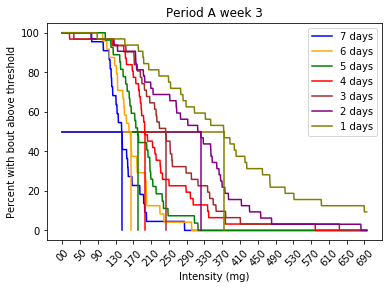

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 4
0.29773978315262717, 0.2309841534612177, 0.18149291075896581, 0.16192660550458715, 0.1538698915763136, 0.1348790658882402, 0.11473728106755629, 

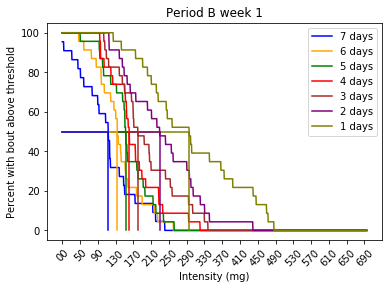

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 5
0.33169307756463723, 0.22120100083402836, 0.21371976647206006, 0.1791909924937448, 0.17631359466221852, 0.15099249374478732, 0.14696413678065054, 

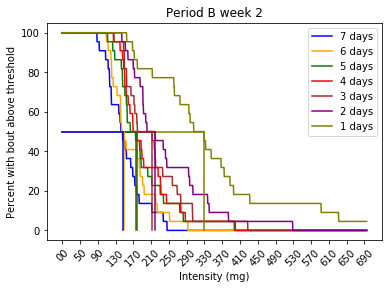

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 6
0.2988907422852377, 0.2499749791492911, 0.20969140950792328, 0.18609674728940784, 0.16940783986655547, 0.15329441201000835, 0.1400583819849875, 

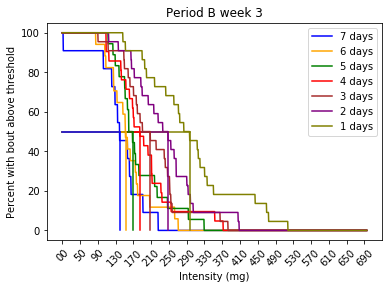

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 7
0.42434528773978314, 0.28450375312760634, 0.274720600500417, 0.2258048373644704, 0.1918515429524604, 0.16940783986655547, 0.1296997497914929, 

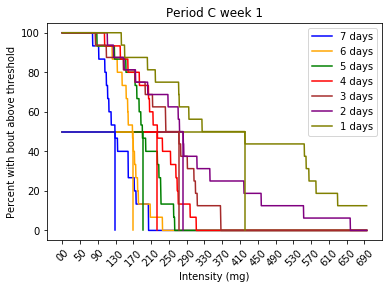

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 8
0.35125938281901586, 0.27414512093411175, 0.238465387823186, 0.21659716430358633, 0.18839866555462886, 0.1653794829024187, 0.15904920767306088, 

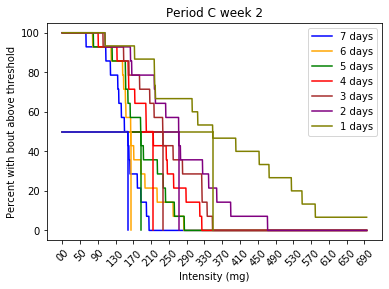

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 9
0.304070058381985, 0.2827773144286906, 0.24191826522101753, 0.23386155129274397, 0.2142952460383653, 0.18724770642201835, 0.15732276897414513, 

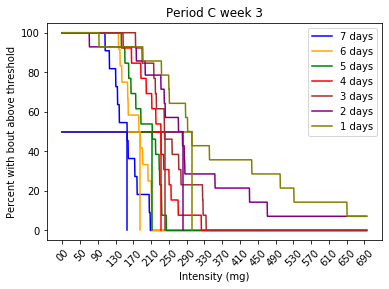

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 1


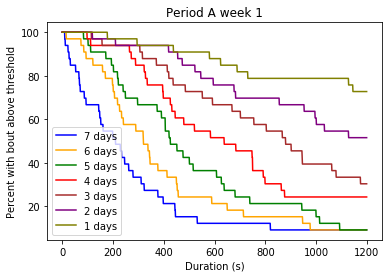

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 2


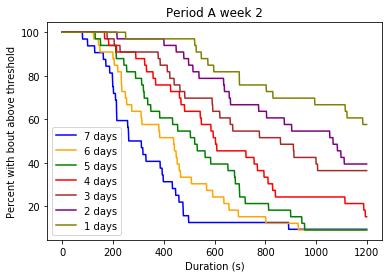

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 3


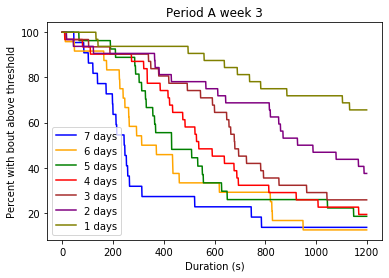

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 4


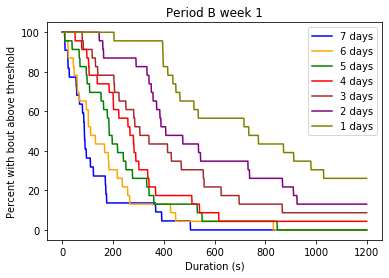

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 5


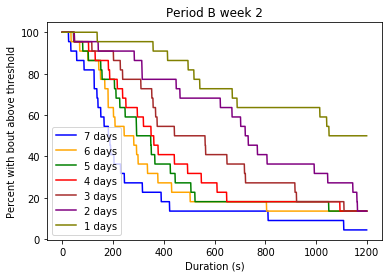

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 6


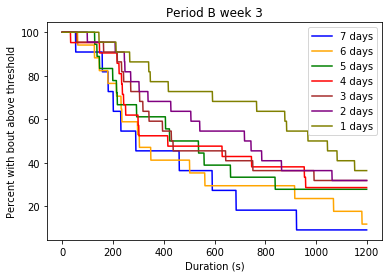

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 7


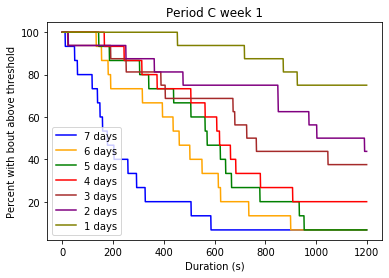

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 8


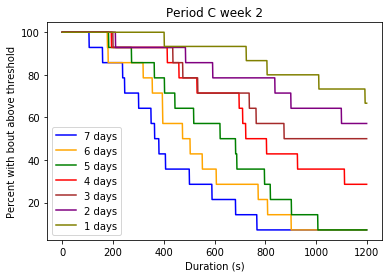

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Figure 9


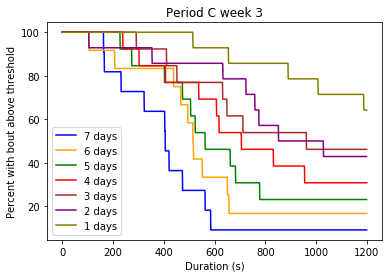

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=


In [21]:
files = [(A,'A', 0), (B,'B', 1), (C,'C', 2)]
for i in files:
    for j in np.arange(3):
        print('Figure ' + str((i[2]*3 + j)+1))
        plots_int(i[0], i[1], j)
        
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
        
files = [(A,'A', 0), (B,'B', 1), (C,'C', 2)]
for i in files:
    for j in np.arange(3):
        print('Figure ' + str((i[2]*3 + j)+1))
        X = plots_dur(i[0], i[1], j)
        
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.metrics import r2_score
import glob


class BarCode:

	def __init__(self, enmo, int_thresholds, duration_thresholds):
		self.entropy = -1
		self.sample_entropy = -1
		self.lzc = -1
		self.percent_active = -1
		self.int_thresholds = int_thresholds
		self.dur_thresholds = duration_thresholds
		self.sbs_enmo = enmo
		self.barcode = self.create_barcode()
		self.no_classes = np.concatenate(np.array(self.dur_thresholds)).shape[0]
		self.compute_entropy()
		#self.compute_lzc()
		self.compute_percent_active(4)
		self.compute_sample_entropy(3,1)

	def compute_entropy(self):
		entropy = information_entropy(self.barcode[:, 1])
		self.entropy = entropy

	def compute_sample_entropy(self, length, radius):
		self.sample_entropy = sample_entropy(self.barcode[:, 1], length, radius)

	def compute_lzc(self):
		self.lzc = lzc(self.barcode[:, 1])

	def compute_percent_active(self, active_threshold):
		self.percent_active = 100 * np.mean(self.barcode[:, 1] >= active_threshold)

	def create_barcode(self):
		#acc, frequency = read_bin(self.bin)
		#enmo = compute_enmo(acc)
		#econd_by_second_enmo = second_by_second(enmo, frequency)
		return barcoder(self.sbs_enmo, self.int_thresholds, self.dur_thresholds)

class Day:
	def __init__(self, acc_table, freq, threshold, percent, raw_data, day, ID):

		# Proportion of possible seconds covered
		self.size = (acc_table.shape[0]) / 86400
		self.frequency_acc = freq

		#self.valid_hours_acc = np.mean(valid_hours(acc_table[:, 2:5],acc_table[:, 5], self.frequency_acc)) * 24 * self.size
		self.enmo = acc_table[:, 6]
		self.top = np.mean(self.enmo > np.mean(self.enmo))
		self.left = np.sum(self.enmo[self.enmo.shape[0]//2:])/np.sum(self.enmo)
		event_list = create_events(np.minimum(acc_table[:, 6], threshold), threshold, percent)
		event_list = np.array([x for x in event_list if x[1]>9])

		self.event_tab = [Event(x[0], x[1], acc_table[x[0]:(x[0] + x[1]), 6],
                                raw_data[(freq*x[0]):(freq*(x[0] + x[1]))], self.frequency_acc) 
                                for x in  event_list]
		self.Day_tab = pd.DataFrame([x.print_all() for x in self.event_tab])
		self.barcode = BarCode(self.enmo)
		self.Day_tab['entropy'] = self.barcode.entropy
		#self.Day_tab['lzc'] = self.barcode.lzc
		self.Day_tab['sample'] = self.barcode.sample_entropy
		self.Day_tab['top'] = self.top
		self.Day_tab['left'] = self.left
		self.Day_tab['ID'] = ID
		self.Day_tab['Day'] = day


class Event:

	def __init__(self, start, length, acc, y_acc, freq):
		self.start_loc = start
		self.end_loc = start + length
		self.duration = length
		self.volume = np.sum(acc)
		self.sd = np.std(acc)
		self.intensity = self.volume / self.duration
		self.ptp = np.ptp(acc)
		self.freq = freq
		self.steps = self.stepper(y_acc)

	def stepper(self, acc):
		upper_filter = 5
		lower_filter = 0.5

		filtered = cheby_bandpass_filter(acc.flatten(),
		lowcut=lower_filter, highcut=upper_filter, fs=self.freq, order=2)

		cadence = compute_cadence(filtered, 0.1, self.freq)
		return cadence.shape[0] * 2

	def print_all(self):
		return np.array([self.start_loc, self.end_loc, self.duration, self.volume, self.sd, self.intensity, self.ptp, self.steps])


def plots_int(FILES, name, week):
	p = np.array([[x.Day_tab[4].max()for x in y[2] if 4 in x.Day_tab.columns] for y in FILES if len(y[2])>20])
	for i in range(p.shape[0]):
		p[i] = np.concatenate((np.array(p[i]), np.array(np.zeros(22-len(p[i])))))

	q = np.zeros((p.shape[0], 22))
	for i in np.arange(p.shape[0]):
		q[i] = p[i]
	weeks = np.zeros(3, dtype = np.object)
	weeks[0] = q[:, 0:7]
	weeks[1] = q[:, 7:14]
	weeks[2] = q[:, 14:21]

	scores = np.zeros((1200, 7))
	for ix, i in enumerate(np.linspace(0.01, 0.7, num = 1200)):
		for j in np.arange(7):

			scores[ix][j] = (np.sum(np.nansum(weeks[week] >= i, 1) >= j+1) * 100)/np.sum((weeks[week] > 0), 0)[j]
            

	plt.title('Period ' + str(name) + ' week ' + str(week+1))
	plt.plot(scores[:, 6], label = '7 days', color = 'b')
	plt.plot(scores[:, 5], label = '6 days', color = 'orange')
	plt.plot(scores[:, 4], label = '5 days', color = 'g')
	plt.plot(scores[:, 3], label = '4 days', color = 'r')
	plt.plot(scores[:, 2], label = '3 days', color = 'brown')
	plt.plot(scores[:, 1], label = '2 days', color = 'purple')
	plt.plot(scores[:, 0], label = '1 days', color = 'olive')
	plt.xlabel('Intensity (mg)')
	plt.xticks([0, 70, 140, 210, 280, 350, 420, 490, 560, 630, 700, 770, 840, 910, 980, 1050, 1120, 1190], 
               ('00', '50', '90','130', '170', '210', '250', '290','330', '370','410', '450', '490','530', '570', '610','650', '690', '730'), rotation = 45)
	plt.legend()
	plt.ylabel('Percent with bout above threshold')
    
	cols = ['b', 'orange', 'g', 'r', 'brown','purple','olive'][::-1]
	medians_loc = [np.where(scores[:, j]<50)[0][0] for j in np.arange(0,7)]
	for j, i in enumerate(medians_loc):
		plt.plot([i, i], [0, 50], color = cols[j])
		plt.plot([0, i], [50, 50], color = cols[j])
		print(np.linspace(0.01, 0.7, num = 1200)[i], end = ", ")     
	plt.show()

	return scores

def plots_dur(FILES, name, week):
	p = np.array([[x.Day_tab[2].max()for x in y[2] if 2 in x.Day_tab.columns] for y in FILES if len(y[2])>20])
	for i in range(p.shape[0]):
		p[i] = np.concatenate((np.array(p[i]), np.array(np.zeros(22-len(p[i])))))

	q = np.zeros((p.shape[0], 22))
	for i in np.arange(p.shape[0]):
		q[i] = p[i]
	weeks = np.zeros(3, dtype = np.object)
	weeks[0] = q[:, 0:7]
	weeks[1] = q[:, 7:14]
	weeks[2] = q[:, 14:21]

	scores = np.zeros((2400, 7))
	for ix, i in enumerate(np.arange(0, 2400)):
		for j in np.arange(7):

			scores[ix][j] = (np.sum(np.nansum(weeks[week] >= i+1, 1) >= j+1) * 100)/np.sum((weeks[week] > 0), 0)[j]
            

	plt.title('Period ' + str(name) + ' week ' + str(week+1))
	plt.plot(scores[:, 6], label = '7 days', color = 'b')
	plt.plot(scores[:, 5], label = '6 days', color = 'orange')
	plt.plot(scores[:, 4], label = '5 days', color = 'g')
	plt.plot(scores[:, 3], label = '4 days', color = 'r')
	plt.plot(scores[:, 2], label = '3 days', color = 'brown')
	plt.plot(scores[:, 1], label = '2 days', color = 'purple')
	plt.plot(scores[:, 0], label = '1 days', color = 'olive')
	plt.xlabel('Duration (s)')
	plt.legend()
	plt.ylabel('Percent with bout above threshold')
	
    
	cols = ['b', 'orange', 'g', 'r', 'brown','purple','olive'][::-1]
	medians_loc = [np.where(scores[:, j]<50)[0][0] for j in np.arange(0,7)]
	for j, i in enumerate(medians_loc):
		plt.plot([i, i], [0, 50], color = cols[j])
		plt.plot([0, i], [50, 50], color = cols[j])
		print(i, end = ", ")     
	     
	plt.show()

	return scores


A_Files = glob.glob('D:\\KNEE\\[0-9]?[A]*bin.npy')
B_Files = glob.glob('D:\\KNEE\\[0-9]?[B]*bin.npy')
C_Files = glob.glob('D:\\KNEE\\[0-9]?[C]*bin.npy')

C = np.array([np.load(x, allow_pickle = True) for x in C_Files])
B = np.array([np.load(x, allow_pickle = True) for x in B_Files])
A = np.array([np.load(x, allow_pickle = True) for x in A_Files])


